# Домашнее задание по теме "Ансамблирование"

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

 Загружаем данные. 

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Подготавливаем данные для обработки.

In [4]:
# Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

# Признак "MSSubClass" явно категориальный, хотя и имеет тип integer. Добавим его вручную
cat_feat.append('MSSubClass')

# Закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

In [5]:
# Отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

# Заполним пропуски специальным значением
data[num_feat] = data[num_feat].fillna(-999)

In [6]:
# Создаём дамми-переменные для категориальных признаков
dummy = pd.get_dummies(data[cat_feat], columns=cat_feat)

In [7]:
# Разбиваем данные
from sklearn.model_selection import train_test_split 

X = pd.concat([data[num_feat], dummy], axis=1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Создаём и обучаем случайный лес. Для оценки качества модели используем 10-fold КВ.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

clf_rf = RandomForestRegressor()
kf = KFold(n_splits=10)
scores = cross_val_score(clf_rf, X_train, y_train, cv=kf)
scores.mean(), scores

(0.8263161700119278,
 array([0.82688869, 0.90790974, 0.67441393, 0.61516603, 0.86856427,
        0.87873843, 0.8650775 , 0.8869763 , 0.82757329, 0.91185352]))

Модель показала хорошие результаты, средний скор равен 0.83. 

Выведем важность признаков.

<function matplotlib.pyplot.show(close=None, block=None)>

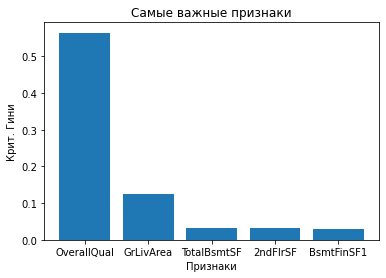

In [10]:
clf_rf.fit(X_train, y_train)
imp = pd.Series(clf_rf.feature_importances_)
imp.index = pd.Series(X_train.columns)
plt.title('Самые важные признаки')
plt.xlabel('Признаки')
plt.ylabel('Крит. Гини')
plt.bar(imp.sort_values(ascending=False).head(5).index, imp.sort_values(ascending=False).head(5))
plt.show

Обучим стекинг.

In [11]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [13]:
sr = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('kn', KNeighborsRegressor()),
        ('dt', DecisionTreeRegressor())
    ], RidgeCV())

sr.fit(X_train, y_train)

for est in sr.estimators_:
    print('{} : {}'.format(est, est.score(X_test, y_test)))
    
print('Stacking Regressor: {}'.format(sr.score(X_test, y_test)))

LinearRegression() : 0.40645343202670825
KNeighborsRegressor() : 0.6921109994924753
DecisionTreeRegressor() : 0.7684000728380846
Stacking Regressor: 0.7922374878522733


Как видим, линейная регрессия показала весьма посредственный результат на тестовой выборке. Метод k-ближайших показал неплохую точность на тестовой выборке, но ниже, чем у модели на основе дерева решений. Ансамблевая модель же продемонстрировала наилучший результат, обеспечив прирост на несколько процентных пунктов по сравнению с деревом решений.